# <center> **XGBoost Model Building**

## **1. Introduction**

- This activity is a continuation of the airlines project in which we built decision tree and random forest models. 
- We will use the same data, but this time you will train, tune, and evaluate an XGBoost model. 
- We’ll then compare the performance of all three models and decide which model is best. 
- Finally, We’ll explore the feature importances of your model and identify the features that most contribute to customer satisfaction.

## **2. Imports**

In [2]:
# Import relevant libraries and modules.

import numpy as np
import pandas as pd
import matplotlib as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# import the data: 
file = r"C:\Users\barba\OneDrive\Documents\AIO Python\Datasets\Invistico_Airline.csv" # Airline_dataset on github
invistico = pd.read_csv(file)
invistico.head()


,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


## **2. Exploration**

In [ ]:
# XGBoost requires less data processing and handles missing values very well. 
invistico.dtypes
invistico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

## **3. Model preparation**

- **Question:** Which metrics are most suited to evaluating this type of model?
    - As this is a **`binary classfication problem`**, it will be important to evaluate not just accuracy. 
    - We must take into account the balance of **`false positives`** and **`false negatives`** that the model's predictions provide. 
    - Therefore, **`precision`**, **`recall`**, and ultimately the **`F1 score`** will be excellent metrics to use.
    - The **`ROC AUC`** (Area Under the Receiver Operating Characteristic) score is also suited to this type of modeling.

#### **3.1. Prepare your data for predictions**

- You may have noticed when previewing your data that there are several non-numerical variables (`object` data types) within the dataset.
- To prepare this DataFrame for modeling, first convert these variables into a numerical format.

In [8]:
# Convert the object predictor variables to numerical dummies.

invistico = pd.get_dummies(invistico,
                           columns=['satisfaction','Customer Type','Type of Travel','Class'],
                           drop_first=True)

#### **3.2. Isolate your target and predictor variables**

In [11]:
# Define the y (target) variable.
y = invistico['satisfaction_satisfied']

# Define the X (predictor) variables.
X = invistico.copy().drop('satisfaction_satisfied', axis = 1)

#### **3.3. Divide your data**

In [12]:
# Perform the split operation on your data.
# Assign the outputs as follows: X_train, X_test, y_train, y_test.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## **4. Model Building**

#### **4.1. "Instantiate" your XGBClassifer**

- Before you fit your model to your airline dataset, first create the XGB Classifier model and define its objective. 
- You'll use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [13]:
# Define xgb to be your XGBClassifier.

xgb = XGBClassifier(objective='binary:logistic', random_state=0)

#### **4.2. Define the parameters for hyperparameter tuning**

- We identify suitable for hyperparameter tuning. 
- Specifically, **`max_depth`**, **`min_child_weight`**, **`learning_rate`**, **`n_estimators`**,  
**`subsample`**, **`colsample_bytree`**.
- Consider a more limited range for each hyperparameter to allow for timely iteration and model training. 
- For example, using a single possible value for each of the six hyperparameters listed above will take  
approximately one minute to run on this platform.
- If you add just one new option, for example by changing **`max_depth: [4]`** to **`max_depth: [3, 6]`**,  
and keep everything else the same, you can expect the run time to approximately double.  
If you use two possibilities for each hyperparameter, the run time would extend to ~1 hour. 
- More estimators will initially improve the model's performance. However, increasing the number of estimators  
will also considerably increase the time spent during the GridSearch process,  
and there will be diminishing returns as the number of estimators continues to increase.

In [20]:
# Define parameters for tuning as `cv_params`.
cv_params = {'max_depth': [4, 6],
             'min_child_weight': [3, 5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [5,10,15],
             'subsample': [0.7],
             'colsample_bytree': [0.7]
              }
# Define your criteria as `scoring`.

scoring = ('accuracy', 'precision', 'recall', 'f1')

#### **4.3. Construct the GridSearch cross-validation** 

- Construct the GridSearch cross-validation using the model, parameters, and scoring metrics you defined. 
- Additionally, define the number of folds and specify **_which metric_** from above will guide the refit strategy.

In [21]:
# Construct your GridSearch.
xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'f1'
                     )

#### **4.4. Fit the GridSearch model to your training data**

In [22]:
%%time
# fit the GridSearch model to training data

xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: total: 8min 22s
Wall time: 1min 12s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', scoring=('accuracy', 'precision', 'recall', 'f1'))

In [23]:
xgb_cv.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=15,
              n_jobs=None, num_parallel_tree=None, ...)

**Question:** Which optimal set of parameters did the GridSearch yield?

Through accessing the **`best_params_`** attribute of the fitted GridSearch model, the optimal set of hyperparameters was:

{**`'colsample_bytree': 0.7`**,  
 **`'learning_rate': 0.3`**,  
  **`'max_depth': 6`**,  
  **`'min_child_weight': 3`**,  
  **`'n_estimators': 15`**,  
  }

#### **4.5. Save your model for reference using `pickle`**

In [24]:
# Use `pickle` to save the trained model.
pickle.dump(xgb_cv, open('xgb_cv.sav', 'wb'))

## **5. Results & Evaluation**

#### **5.1. Formulate predictions on your test set**

- To evaluate the predictions yielded from the model, leverage a series of metrics and evaluation techniques from scikit-learn by examining the actual observed values in the test set relative to your model's prediction.
- First, use your trained model to formulate predictions on your test set.

In [25]:
# Apply your model to predict on your test data. Call this output "y_pred".
y_pred = xgb_cv.predict(X_test)

#### **5.2. Leverage metrics to evaluate your model's performance**

- Apply a series of metrics from scikit-learn to assess your model. 
- Specifically, print the accuracy score, precision score, recall score, and f1 score associated with your test data and predicted values.

In [26]:
# 1. Print your accuracy score.
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

# 2. Print your precision score.
pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

# 3. Print your recall score.
rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

# 4. Print your f1 score.
f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9310748383122882
precision score: 0.9401217861975643
recall score: 0.9341176470588235
f1 score: 0.9371100994773225


- The **`accuracy score`** for this model is 0.931, or 93.1% accurate. 
- In classification problems, accuracy is useful to know but may not be the best metric to evaluate this model.
- **`Precision and recall scores`** are both useful to evaluate the correct predictive capability of the model because they balance the **`false positives`** and **`false negatives`** inherent in prediction. 
- The model shows a precision score of 0.940, suggesting the model is very good at predicting true positives. 
- This means the model correctly predicts whether the airline passenger will be satisfied. 
- **`The recall`** score of 0.934 is also very good. This means that the model does a good job of correctly identifying dissatisfied passengers within the dataset.
- These two metrics combined give a better assessment of model performance than the accuracy metric does alone.
- The **`F1 score`** balances the precision and recall performance to give a combined assessment of how well this model delivers predictions. 
- In this case, the F1 score is 0.937, which suggests very strong predictive power in this model.

#### **5.3. Gain clarity with the confusion matrix**

- Recall that a **confusion matrix** is a graphic that shows a model's true and false positives and true and false negatives. 
- It helps to create a visual representation of the components feeding into the metrics above.
- Create a confusion matrix based on your predicted values for the test set.

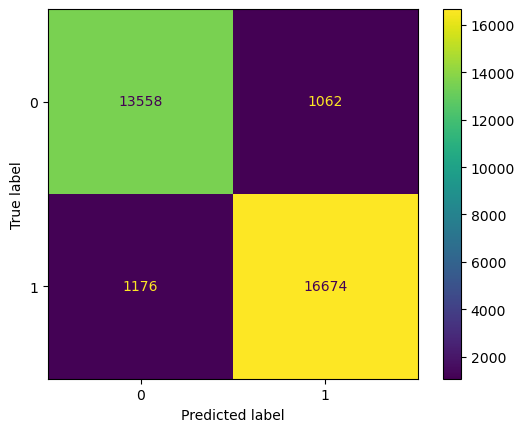

In [ ]:
# Construct and display your confusion matrix.
# Construct the confusion matrix for your predicted and test values.
# Plot the visual.
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= xgb_cv.classes_).plot();


- The top left to bottom right diagonal in the confusion matrix represents the correct predictions, and the ratio of these squares showcases the accuracy.
- Additionally, the concentration of true positives and true negatives stands out relative to false positives and false negatives, respectively.
- This ratio is why the precision score is so high (0.944).

#### **5.4. Visualize most important features**

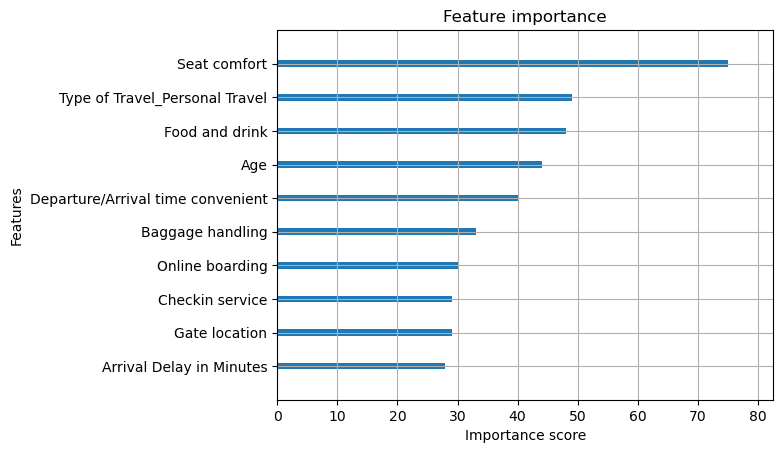

In [34]:
plot_importance(xgb_cv.best_estimator_,
                grid=True,
                max_num_features = 10,
                show_values = False
                );

- By a wide margin, "seat comfort" rated as most important in the model.
- The type of seating is very different between first class and coach seating.
- However, the perks of being in first class also go beyond the seating type, so perhaps that is an underlying explanation of this feature's importance.
- Surprisingly, delays (both arrival and departure) did not score as highly important.

### **5.5. Compare models**

In [41]:
# Compare the different models : 
table_1 =  pd.DataFrame({'Model': [ "Tuned XGBoost"],
                      'F1': [ f1_score],
                      'Recall': [ rc_score],
                      'Precision': [ pc_score],
                      'Accuracy': [ ac_score]
                     }
                    )

table_1
table = pd.read_csv("table_airline.csv", index_col=0)

table = pd.concat([table, table_1] )
table 

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.944238,0.934426,0.954280,0.939587
1,Tuned Random Forest,0.947306,0.944501,0.950128,0.942450
0,Tuned XGBoost,0.937110,0.934118,0.940122,0.931075


- Based on the results shown in the table above, the F1, precision, recall, and accuracy scores of the XGBoost model are similar to the corresponding scores of the decision tree and random forest models.
- **`The random forest model`** seemed to outperform the decision tree model as well as the XGBoost model. 

## **6. Considerations**

- #### **6.1. Key takeaways**
    - The evaluation of the model is important to inform if the model has delivered accurate predictions.
    - Splitting the data is important for ensuring that there is new data for the model to test its predictive performance.
    - Each metric provides an evaluation from a different standpoint, and accuracy alone is not a strong way to evaluate a model.
    - Effective assessments balance the true/false positives versus true/false negatives through the confusion matrix and F1 score.

- #### **6.2. Share Findings with the team**
    - Showcase the data used to create the prediction and the performance of the model overall.
    - Review the sample output of the features and the confusion matrix to reference the model's performance.
    - Highlight the metric values, emphasizing the F1 score.
    - Visualize the feature importance to showcase what drove the model's predictions.

- #### **6.3. What would you share with and recommend to stakeholders?**
    - The model created is highly effective at predicting passenger satisfaction.
    - The feature importance of seat comfort warrants additional investigation. 
    - It will be important to ask domain experts why they believe this feature scores so highly in this model.